# Assignment 3 - Transfer Learning
 
**Authors:**

1.   Liav Bachar 205888472
2.   Naor Kolet 205533060


# 0. Imports

In [1]:
import pandas as pd
import numpy as np



# TensorFlow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB4,  MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import max_norm

# Scikit-learn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss
 
# Plots
# import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
from scipy.io import loadmat
import os
import random
import joblib
import cv2
from glob import glob
from tqdm import tqdm_notebook as tqdm

%matplotlib inline



In [14]:
SEED = 42
def set_seed():    
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Download Data

In [3]:
# Another dataset? https://www.tensorflow.org/tutorials/load_data/images
if not os.path.exists(r'./datasets/'):
    !mkdir ./datasets
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' -P './datasets/'
    !tar -xf ./datasets/102flowers.tgz -C ./datasets/
    
#     !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz' -P './datasets/'
    
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' -P './datasets/'
    
labels = loadmat('./datasets/imagelabels.mat')['labels'].reshape(-1)

## Load Images

In [4]:
images_path = glob('./datasets/jpg/*')
images_path.sort()

In [5]:
def split_train_val_test(split_seed):
    # train 50% validation 25% test 25%
    train_paths, val_tst_paths, train_labels, val_tst_labels = train_test_split(images_path, labels, train_size=0.5, random_state=split_seed, shuffle=True, stratify=labels)
    val_paths, tst_paths, val_labels, tst_labels = train_test_split(val_tst_paths, val_tst_labels, train_size=0.5, random_state=split_seed, shuffle=True, stratify=val_tst_labels)
    
    def convert2df(paths, labels): return pd.DataFrame({'filename': paths, 'class':labels}).astype(str)
    train_df = convert2df(train_paths, train_labels)
    val_df = convert2df(val_paths, val_labels)
    test_df = convert2df(tst_paths, tst_labels)
    
    return train_df, val_df, test_df

In [6]:
def balance_data_by_resample(df, per_class=128):

    dfs = [df[df['class'] == i] for i in train_df['class'].unique()]
#     per_class = max(per_class, max([df.shape[0] for df in dfs]))

    def resample(df):
        sample_amt = per_class - df.shape[0]
        if sample_amt > 0:
            sample_dfs = [df]
            while sample_amt:
                curr_amt = min(sample_amt, df.shape[0])
                sample_df = df.sample(curr_amt)
                sample_dfs.append(sample_df)
                sample_amt -= curr_amt

            return pd.concat(sample_dfs)
        
        if sample_amt < 0:
            return df.sample(per_class)

        return df

    dfs_resample = [resample(df) for df in dfs]
    
    return pd.concat(dfs_resample)


## Image Data Generator

In [7]:
def datagen_flow(df, batch_size, resize_shape, subset):
    classes = list(np.unique(labels).astype(str))
    
    if subset == 'traino':
        data_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
#              rescale=1./255
            preprocessing_function=preprocess_input
           )
    else:
        data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
        
    return data_gen.flow_from_dataframe(df, batch_size=batch_size, target_size=resize_shape, seed=SEED, validate_filenames=False, classes=classes, shuffle=True)

# Pre-trained models

In [8]:
def get_feature_extractor(base_model, width=224, height=224, channel=3):
    model = base_model(input_shape=(width, height, channel), include_top=False)
    
    trainable = False
    for layer in model.layers:
        if base_model.__name__ == 'ResNet50V2' and 'conv5' in layer.name:
            trainable = True
            
        layer.trainable = trainable
        
            
    return Model(model.input, model.output, name=base_model.__name__)


In [9]:

output_shape = 102

# Building the base model

## Model Architecture

<!-- Here we build our model architecture. It contains 4 main parts.

1. **Embedding Layer** - Here the words of each song will be converted to their embeddings representations. We made this layer trainable, let the model learn the embeddings for the missing words.
2. **Concatenate Layer** - Here we attach for each word entry the related melody record
3. **LSTM Layers** - Here we created two layers of lstm, the first one learn features across the windows and outputs all the hidden states, the next one gets those hidden states and output a single feature that was learnt from them.
4. **Softmax Layer** - Give each word in our dictionary the probabilty it will be the next word after the window.

Note: We are using Dropout layers in order to reduce the overfitting -->

## Training Framework

In [10]:
def get_callbacks(model_name):
    acc = 'val_acc'
    acc_mode = 'max'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=13)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 7,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR]  #earlystop

In [11]:
def train_model(model_gen, fe_type, train_df, val_df, use_saved=False, params_dict=None):
    os.makedirs('./models', exist_ok=True)
    params = ''
    if params_dict is not None:
        params = '_'.join(f'{key}_{val}' for key,val in params_dict.items())
    model_name = f'{fe_type}' + f'_{params}'
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        train_flow = datagen_flow(train_df, params_dict['batch_size'], image_shape[:-1], 'train')
        val_flow = datagen_flow(val_df, params_dict['batch_size'], image_shape[:-1], 'val')
        
        model = model_gen(image_shape, output_shape, fe_type)
#         model = load_model(fr'./models/{model_name}.h5')
        history = model.fit(
                            x=train_flow,
                            y=None,
                            batch_size=None,
                            epochs=params_dict['epochs'],
                            validation_data=val_flow,
                            callbacks=callbacks,
                            steps_per_epoch = params_dict['steps'],
                            validation_steps = params_dict['validation_steps'],
                            workers=5
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

In [12]:
def visualize_perf(history):
    fig, ax = plt.subplots(ncols=2, figsize=(5*2,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['loss', 'val_loss']:
        ax[0].plot(history[k])
        
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].margins(0.01)
    ax[0].set_title('Crossentropy')
    
    for k in ['acc', 'val_acc']:
        ax[1].plot(history[k])
        
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].margins(0.01)
    ax[1].set_title('Accuracy')
    
    plt.show()

## Model Learning

In [24]:
 def init_model(image_shape, output_shape, fe_type='vgg'):
    inp = Input(shape=image_shape, name='image')
    
    if fe_type == 'vgg':
        X = get_feature_extractor(VGG16, width=224, heigh=224)(inp)
    elif fe_type == 'resnet':
        X = get_feature_extractor(ResNet50V2, width=224, height=224)(inp)
    elif fe_type == 'mobile_net':
        X = get_feature_extractor(MobileNetV2, width=160, height=160)(inp)
    else:
        X = inp
    
    
    X = MaxPool2D(pool_size=(3, 3))(X)
    X = Flatten()(X)
#     X = Dropout(0.5)(X)
    X = Dense(512, activation="relu",  kernel_regularizer=tf.keras.regularizers.L2(0.01))(X)
    X = Dropout(0.5)(X)
    X = Dense(256, activation="relu",  kernel_regularizer=tf.keras.regularizers.L2(0.01))(X)
    X = Dropout(0.5)(X)
    out = Dense(output_shape, activation="softmax", name = 'out')(X)

    model = Model(inp, out)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])
    
    return model
    

In [ ]:
def evaluate_model(model_gen, fe_type, k=5, params_dict=None):
    histories = []
    losses = []
    accs = []
    
    for i in range(k):
        print(f'Training model {i+1}')
        
        set_seed()
        
        train_df, val_df, test_df = split_train_val_test(SEED+i)
        curr_model, curr_history = train_model(model_gen, fe_type, train_df, val_df, params_dict=params_dict)
        
        
        test_flow = datagen_flow(test_df, params_dict['batch_size'], image_shape[:-1], 'test')
        curr_loss, curr_acc = curr_model.evaluate(test_flow, steps=params_dict['validation_steps'])
        
        histories.append(curr_history)
        losses.append(curr_loss)
        accs.append(curr_acc)
        
        del curr_model
        tf.keras.backend.clear_session()
        
    print(f'Test CrossEntropy: {np.mean(losses):.4f} +-{np.std(losses):.4f}')
    print(f'Test Accuracy: {np.mean(accs)*100:.2f}% +-{np.std(accs)*100:.2f}%')
    
    return histories




def visualize_perf(history_per_fold):
    k = len(history_per_fold)
    fig, ax = plt.subplots(nrows=2, ncols=k, figsize=(k*5,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(f'Model performance over epochs')
    
    for fold_no, h in enumerate(history_per_fold):

        for k in ['loss', 'val_loss']:
            ax[0,fold_no].plot(h[k])
            ax[0,fold_no].legend(['train_loss', 'val_loss'])
            ax[0,fold_no].margins(0.01)
            ax[0,fold_no].set_title(f'Fold #{fold_no+1} - loss')

        for k in ['acc', 'val_acc']:
            ax[1,fold_no].plot(h[k])
            ax[1,fold_no].legend(['train_acc', 'val_acc'])
            ax[1,fold_no].margins(0.01)
            ax[1,fold_no].set_title(f'Fold #{fold_no+1} - accuracy')





params_dict = {
    'epochs': 20,
    'batch_size': 32,
    'steps': 127,
    'validation_steps':63
}

image_shape = (224, 224, 3)
resnet_histories = evaluate_model(init_model, 'resnet', k=2, params_dict=params_dict)
visualize_perf(resnet_histories)




Training model 1
Found 4094 non-validated image filenames belonging to 102 classes.
Found 2047 non-validated image filenames belonging to 102 classes.
Epoch 1/20
127/127 [==============================] - 19s 125ms/step - loss: 16.3229 - acc: 0.0335 - val_loss: 10.3701 - val_acc: 0.1419
Epoch 2/20
127/127 [==============================] - 15s 119ms/step - loss: 8.1324 - acc: 0.1907 - val_loss: 5.6243 - val_acc: 0.3705
Epoch 3/20
127/127 [==============================] - 16s 120ms/step - loss: 5.2224 - acc: 0.3622 - val_loss: 4.3173 - val_acc: 0.4707
Epoch 4/20
127/127 [==============================] - 16s 121ms/step - loss: 3.7529 - acc: 0.5187 - val_loss: 3.1468 - val_acc: 0.6548
Epoch 5/20
127/127 [==============================] - 15s 118ms/step - loss: 2.9320 - acc: 0.6420 - val_loss: 2.5170 - val_acc: 0.7594
Epoch 6/20
127/127 [==============================] - 15s 119ms/step - loss: 2.3800 - acc: 0.7495 - val_loss: 2.0677 - val_acc: 0.8269
Epoch 7/20
127/127 [=================

## MobileNet

In [28]:
params_dict = {
    'epochs': 20,
    'batch_size': 32,
    'steps': 127,
    'validation_steps':63
}

mobile_net_model, mobile_net_history = train_model(init_model, 'mobile_net', train_df, val_df, params_dict=params_dict)

# del vgg_model
tf.keras.backend.clear_session()

Found 4094 non-validated image filenames belonging to 102 classes.
Found 2047 non-validated image filenames belonging to 102 classes.
Epoch 1/20
127/127 [==============================] - 22s 151ms/step - loss: 9.8021 - acc: 0.0450 - val_loss: 7.6439 - val_acc: 0.2202
Epoch 2/20
127/127 [==============================] - 19s 149ms/step - loss: 7.1214 - acc: 0.3019 - val_loss: 6.3163 - val_acc: 0.4266
Epoch 3/20
127/127 [==============================] - 18s 140ms/step - loss: 5.7220 - acc: 0.5603 - val_loss: 5.4406 - val_acc: 0.5799
Epoch 4/20
127/127 [==============================] - 19s 146ms/step - loss: 4.8592 - acc: 0.7084 - val_loss: 4.8817 - val_acc: 0.6567
Epoch 5/20
127/127 [==============================] - 18s 141ms/step - loss: 4.2732 - acc: 0.8085 - val_loss: 4.4993 - val_acc: 0.6989
Epoch 6/20
127/127 [==============================] - 19s 147ms/step - loss: 3.8627 - acc: 0.8818 - val_loss: 4.1978 - val_acc: 0.7302
Epoch 7/20
127/127 [==============================] - 19

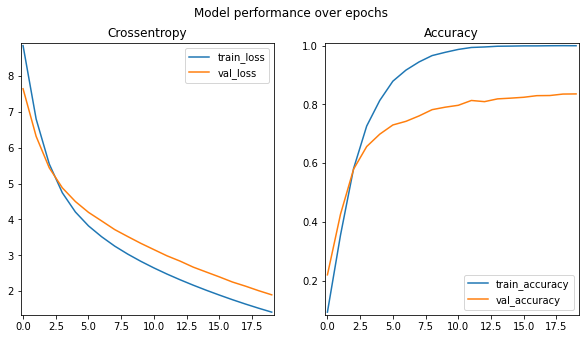

In [29]:
visualize_perf(mobile_net_history)

## ResNet

In [39]:
 def init_model(image_shape, output_shape, fe_type='vgg'):
    inp = Input(shape=image_shape, name='image')
    
    if fe_type == 'vgg':
        X = get_feature_extractor(VGG16, width=224, heigh=224)(inp)
    elif fe_type == 'resnet':
        X = get_feature_extractor(ResNet50V2, width=224, height=224)(inp)
    elif fe_type == 'mobile_net':
        X = get_feature_extractor(MobileNetV2, width=160, height=160)(inp)
    else:
        X = inp
    
    
    X = MaxPool2D(pool_size=(3, 3))(X)
    X = Flatten()(X)
    X = Dense(256, activation="relu",  kernel_regularizer=tf.keras.regularizers.L2(0.01))(X)
    out = Dense(output_shape, activation="softmax", name = 'out')(X)

    model = Model(inp, out)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['acc'])
    
    return model
    

In [40]:
image_shape = (224, 224, 3)
params_dict = {
    'epochs': 10,
    'batch_size': 32,
    'steps': 127,
    'validation_steps':63
}

mobile_net_model, mobile_net_history = train_model(init_model, 'resnet', train_df, val_df, params_dict=params_dict)

# del vgg_model
tf.keras.backend.clear_session()

Found 4094 non-validated image filenames belonging to 102 classes.
Found 2047 non-validated image filenames belonging to 102 classes.
Epoch 1/10
127/127 [==============================] - 26s 181ms/step - loss: 9.9489 - acc: 0.1581 - val_loss: 6.0685 - val_acc: 0.5813
Epoch 2/10
127/127 [==============================] - 22s 167ms/step - loss: 4.4025 - acc: 0.9453 - val_loss: 5.0748 - val_acc: 0.7063
Epoch 3/10
127/127 [==============================] - 21s 163ms/step - loss: 3.7559 - acc: 0.9961 - val_loss: 4.5941 - val_acc: 0.7336
Epoch 4/10
127/127 [==============================] - 21s 162ms/step - loss: 3.4148 - acc: 0.9999 - val_loss: 4.2813 - val_acc: 0.7386
Epoch 5/10
127/127 [==============================] - 21s 165ms/step - loss: 3.1241 - acc: 0.9999 - val_loss: 4.0108 - val_acc: 0.7431
Epoch 6/10
127/127 [==============================] - 21s 163ms/step - loss: 2.8487 - acc: 0.9994 - val_loss: 3.7110 - val_acc: 0.7520
Epoch 7/10
127/127 [==============================] - 21

In [38]:
visualize_perf(mobile_net_history)

TypeError: unhashable type: 'slice'